In [1]:
import numpy as np

In [2]:
"""
@file metrics.py

Holds a variety of metric computing functions for time-series forecasting models
"""
import numpy as np
import scipy.stats as stats

from skimage.filters import threshold_otsu


def mae(output, target, **kwargs):
    """ Gets the mean of the per-step MAE for the given length of timesteps used for training """
    full_pixel_mses = np.abs(output - target)
    sequence_pixel_mse = np.mean(full_pixel_mses, axis=(1, 2))
    return sequence_pixel_mse, np.mean(sequence_pixel_mse), np.std(sequence_pixel_mse)



def mse(output, target, **kwargs):
    """ Gets the mean of the per-pixel MSE for the given length of timesteps used for training """
    full_pixel_mses = (output - target) ** 2
    sequence_pixel_mse = np.mean(full_pixel_mses, axis=(1, 2))
    return sequence_pixel_mse, np.mean(sequence_pixel_mse), np.std(sequence_pixel_mse)


def tcc(u, x, **kwargs):
    m, n, w = u.shape
    res = []
    for i in range(m):
        correlation_sum = 0
        count = 0
        for j in range(n):
            a = u[i, j, :]
            b = x[i, j, :]
            if (a == a[0]).all() or (b == b[0]).all():
                count += 1
                continue
            correlation_sum = correlation_sum + stats.pearsonr(a, b)[0]
        correlation_sum = correlation_sum / (n - count)
        res.append(correlation_sum)
    res = np.array(res)
    return res, np.mean(res), np.std(res)


def scc(u, x, **kwargs):
    m, n, w = u.shape
    res = []
    for i in range(m):
        correlation_sum = 0
        count = 0
        for j in range(w):
            a = u[i, :, j]
            b = x[i, :, j]
            if (a == a[0]).all() or (b == b[0]).all():
                count += 1
                continue
            correlation_sum = correlation_sum + stats.pearsonr(a, b)[0]
        correlation_sum = correlation_sum / (w - count)
        res.append(correlation_sum)
    res = np.array(res)
    return res, np.mean(res), np.std(res)


def dcc(u, x):
    m, n, w = u.shape
    dice_cc = []

    for i in range(m):
        u_row = u[i, :, 50]
        x_row = x[i, :, 50]

        thresh_u = threshold_otsu(u_row)
        u_scar_idx = np.where(u_row >= thresh_u)[0]
        thresh_x = threshold_otsu(x_row)
        x_scar_idx = np.where(x_row >= thresh_x)[0]

        intersect = set(u_scar_idx) & set(x_scar_idx)
        dice_cc.append(2 * len(intersect) / float(len(set(u_scar_idx)) + len(set(x_scar_idx))))

    dice_cc = np.array(dice_cc)
    return dice_cc, np.mean(dice_cc), np.std(dice_cc)

In [3]:
def extract_metrics(model_path, num_tasks=9):
    """Extract Learning Potential and Retained Potential metrics for a model path
    
    Args:
        model_path (str): Path to model directory containing task folders
        num_tasks (int): Number of tasks (default 9 for task_0 through task_8)
        
    Returns:
        dict: Nested dictionary of metrics organized by metric type and potential type
    """
    metrics_dict = {
        'mse': {'LP': [], 'RP': []},
        'mae': {'LP': [], 'RP': []},
        'scc': {'LP': [], 'RP': []},
        'tcc': {'LP': [], 'RP': []},
        'dcc': {'LP': [], 'RP': []}
    }
    
    # Loop through all tasks except the last one (which has no RP)
    for task_id in range(num_tasks - 1):
        try:
            # Learning Potential - Compare task_N predictions with GT for task_N
            lp_gt = np.load(f"{model_path}/task_{task_id}/test_{task_id}/test_{task_id}_signals.npy")
            lp_pred = np.load(f"{model_path}/task_{task_id}/test_{task_id}/test_{task_id}_preds.npy")
            
            # Retained Potential - Compare task_N predictions from final task with GT
            rp_gt = np.load(f"{model_path}/task_{num_tasks-1}/test_{task_id}/test_{task_id}_signals.npy")
            rp_pred = np.load(f"{model_path}/task_{num_tasks-1}/test_{task_id}/test_{task_id}_preds.npy")
            
            # Calculate metrics for both potentials
            # Learning Potential
            _, mse_lp_mean, mse_lp_std = mse(lp_pred, lp_gt)
            _, mae_lp_mean, mae_lp_std = mae(lp_pred, lp_gt)
            _, scc_lp_mean, scc_lp_std = scc(lp_pred, lp_gt)
            _, tcc_lp_mean, tcc_lp_std = tcc(lp_pred, lp_gt)
            _, dcc_lp_mean, dcc_lp_std = dcc(lp_pred, lp_gt)
            
            # Retained Potential
            _, mse_rp_mean, mse_rp_std = mse(rp_pred, rp_gt)
            _, mae_rp_mean, mae_rp_std = mae(rp_pred, rp_gt)
            _, scc_rp_mean, scc_rp_std = scc(rp_pred, rp_gt)
            _, tcc_rp_mean, tcc_rp_std = tcc(rp_pred, rp_gt)
            _, dcc_rp_mean, dcc_rp_std = dcc(rp_pred, rp_gt)
            
            # Store results
            metrics_dict['mse']['LP'].append((mse_lp_mean, mse_lp_std))
            metrics_dict['mae']['LP'].append((mae_lp_mean, mae_lp_std))
            metrics_dict['scc']['LP'].append((scc_lp_mean, scc_lp_std))
            metrics_dict['tcc']['LP'].append((tcc_lp_mean, tcc_lp_std))
            metrics_dict['dcc']['LP'].append((dcc_lp_mean, dcc_lp_std))
            
            metrics_dict['mse']['RP'].append((mse_rp_mean, mse_rp_std))
            metrics_dict['mae']['RP'].append((mae_rp_mean, mae_rp_std))
            metrics_dict['scc']['RP'].append((scc_rp_mean, scc_rp_std))
            metrics_dict['tcc']['RP'].append((tcc_rp_mean, tcc_rp_std))
            metrics_dict['dcc']['RP'].append((dcc_rp_mean, dcc_rp_std))
            
        except Exception as e:
            print(f"Error processing task {task_id}: {str(e)}")
            continue
    
    # Calculate aggregate statistics
    final_metrics = {}
    for metric in metrics_dict:
        final_metrics[metric] = {
            'LP': {
                'mean': np.mean([x[0] for x in metrics_dict[metric]['LP']]),
                'std': np.mean([x[1] for x in metrics_dict[metric]['LP']])
            },
            'RP': {
                'mean': np.mean([x[0] for x in metrics_dict[metric]['RP']]),
                'std': np.mean([x[1] for x in metrics_dict[metric]['RP']])
            }
        }
    
    return final_metrics

def aggregate_seed_metrics(base_path, seeds=[1111, 2222, 3333, 4444, 5555]):
    """Aggregate metrics across multiple seeds for each model type"""
    
    # Initialize storage for all seeds
    seed_metrics = {}
    
    for seed in seeds:
        # Define model paths for this seed
        models = {
            "CoMetaPNS": {
                "NL": f"{base_path}/feedforwardmask_synthetic_continual_naive_{seed}_1.0/feedforwardmask/version_0",
                "RS": f"{base_path}/feedforwardmask_synthetic_continual_task_aware_{seed}_1.0/feedforwardmask/version_0",
                "ER": f"{base_path}/feedforwardmask_synthetic_continual_er_{seed}_1.0/feedforwardmask/version_0"
            },
            "MAML-PNS": {
                "NL": f"{base_path}/maml_synthetic_continual_naive_{seed}_1.0/maml/version_0",
                "RS": f"{base_path}/maml_synthetic_continual_task_aware_{seed}_1.0/maml/version_0", 
                "ER": f"{base_path}/maml_synthetic_continual_er_{seed}_1.0/maml/version_0"
            },
            "PNS": {
                "NL": f"{base_path}/pns_synthetic_continual_naive_{seed}_1.0/pns/version_0",
                "RS": f"{base_path}/pns_synthetic_continual_task_aware_{seed}_1.0/pns/version_0",
                "ER": f"{base_path}/pns_synthetic_continual_er_{seed}_1.0/pns/version_0"
            }
        }
        
        # Get metrics for each model type and memory strategy
        seed_metrics[seed] = {}
        for model_name, strategies in models.items():
            seed_metrics[seed][model_name] = {}
            for strategy_name, model_path in strategies.items():
                try:
                    metrics = extract_metrics(model_path)
                    seed_metrics[seed][model_name][strategy_name] = metrics
                except Exception as e:
                    print(f"Error processing {model_name} {strategy_name} seed {seed}: {e}")
                    continue
    
    # Aggregate across seeds
    final_metrics = {}
    for model_name in seed_metrics[seeds[0]].keys():
        final_metrics[model_name] = {}
        
        for strategy in ["NL", "RS", "ER"]:
            final_metrics[model_name][strategy] = {}
            
            for metric in ["mse", "mae", "scc", "tcc", "dcc"]:
                final_metrics[model_name][strategy][metric] = {
                    "LP": {
                        "mean": np.nanmean([seed_metrics[seed][model_name][strategy][metric]["LP"]["mean"] 
                                       for seed in seeds 
                                       if seed in seed_metrics and strategy in seed_metrics[seed][model_name]]),
                        "std": np.nanmean([seed_metrics[seed][model_name][strategy][metric]["LP"]["std"] 
                                      for seed in seeds 
                                      if seed in seed_metrics and strategy in seed_metrics[seed][model_name]])
                    },
                    "RP": {
                        "mean": np.nanmean([seed_metrics[seed][model_name][strategy][metric]["RP"]["mean"] 
                                       for seed in seeds 
                                       if seed in seed_metrics and strategy in seed_metrics[seed][model_name]]),
                        "std": np.nanmean([seed_metrics[seed][model_name][strategy][metric]["RP"]["std"] 
                                      for seed in seeds 
                                      if seed in seed_metrics and strategy in seed_metrics[seed][model_name]])
                    }
                }
                
                # Calculate BTI as RP - LP
                lp_mean = final_metrics[model_name][strategy][metric]["LP"]["mean"]
                rp_mean = final_metrics[model_name][strategy][metric]["RP"]["mean"]
                final_metrics[model_name][strategy][metric]["BTI"] = {
                    "mean": rp_mean - lp_mean,
                    "std": np.sqrt(final_metrics[model_name][strategy][metric]["LP"]["std"]**2 + 
                                 final_metrics[model_name][strategy][metric]["RP"]["std"]**2)
                }
    
    return final_metrics

# Run aggregation
base_path = "../experiments"
final_metrics = aggregate_seed_metrics(base_path)

# Print results in a formatted way
for model_name, strategies in final_metrics.items():
    print(f"\n{model_name}")
    print("=" * 80)
    for strategy, metrics in strategies.items():
        print(f"\n{strategy}:")
        for metric_name, values in metrics.items():
            print(f"\n{metric_name.upper()}:")
            for potential_type, stats in values.items():
                print(f"{potential_type}: mean={stats['mean']:.4f}, std={stats['std']:.4f}")

Error processing task 2: [Errno 2] No such file or directory: '../experiments/maml_synthetic_continual_naive_1111_1.0/maml/version_0/task_2/test_2/test_2_signals.npy'
Error processing task 3: [Errno 2] No such file or directory: '../experiments/maml_synthetic_continual_naive_1111_1.0/maml/version_0/task_3/test_3/test_3_signals.npy'
Error processing task 4: [Errno 2] No such file or directory: '../experiments/maml_synthetic_continual_naive_1111_1.0/maml/version_0/task_4/test_4/test_4_signals.npy'
Error processing task 5: [Errno 2] No such file or directory: '../experiments/maml_synthetic_continual_naive_1111_1.0/maml/version_0/task_5/test_5/test_5_signals.npy'
Error processing task 6: [Errno 2] No such file or directory: '../experiments/maml_synthetic_continual_naive_1111_1.0/maml/version_0/task_6/test_6/test_6_signals.npy'
Error processing task 7: [Errno 2] No such file or directory: '../experiments/maml_synthetic_continual_naive_1111_1.0/maml/version_0/task_7/test_7/test_7_signals.npy

/home/rxm7244/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rxm7244/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error processing task 0: [Errno 2] No such file or directory: '../experiments/maml_synthetic_continual_naive_4444_1.0/maml/version_0/task_8/test_0/test_0_signals.npy'
Error processing task 1: [Errno 2] No such file or directory: '../experiments/maml_synthetic_continual_naive_4444_1.0/maml/version_0/task_8/test_1/test_1_signals.npy'
Error processing task 2: [Errno 2] No such file or directory: '../experiments/maml_synthetic_continual_naive_4444_1.0/maml/version_0/task_2/test_2/test_2_signals.npy'
Error processing task 3: [Errno 2] No such file or directory: '../experiments/maml_synthetic_continual_naive_4444_1.0/maml/version_0/task_3/test_3/test_3_signals.npy'
Error processing task 4: [Errno 2] No such file or directory: '../experiments/maml_synthetic_continual_naive_4444_1.0/maml/version_0/task_4/test_4/test_4_signals.npy'
Error processing task 5: [Errno 2] No such file or directory: '../experiments/maml_synthetic_continual_naive_4444_1.0/maml/version_0/task_5/test_5/test_5_signals.npy

In [4]:
import json
with open("../experiments/total_metrics.json", 'w') as f:
    json.dump(final_metrics, f)

TypeError: Object of type float32 is not JSON serializable

Error plotting PNS LP mse: name 'final_metrics' is not defined
Error plotting MAML-PNS LP mse: name 'final_metrics' is not defined
Error plotting CoMetaPNS LP mse: name 'final_metrics' is not defined
Error plotting PNS RP mse: name 'final_metrics' is not defined
Error plotting MAML-PNS RP mse: name 'final_metrics' is not defined
Error plotting CoMetaPNS RP mse: name 'final_metrics' is not defined
Error plotting PNS BTI mse: name 'final_metrics' is not defined
Error plotting MAML-PNS BTI mse: name 'final_metrics' is not defined
Error plotting CoMetaPNS BTI mse: name 'final_metrics' is not defined


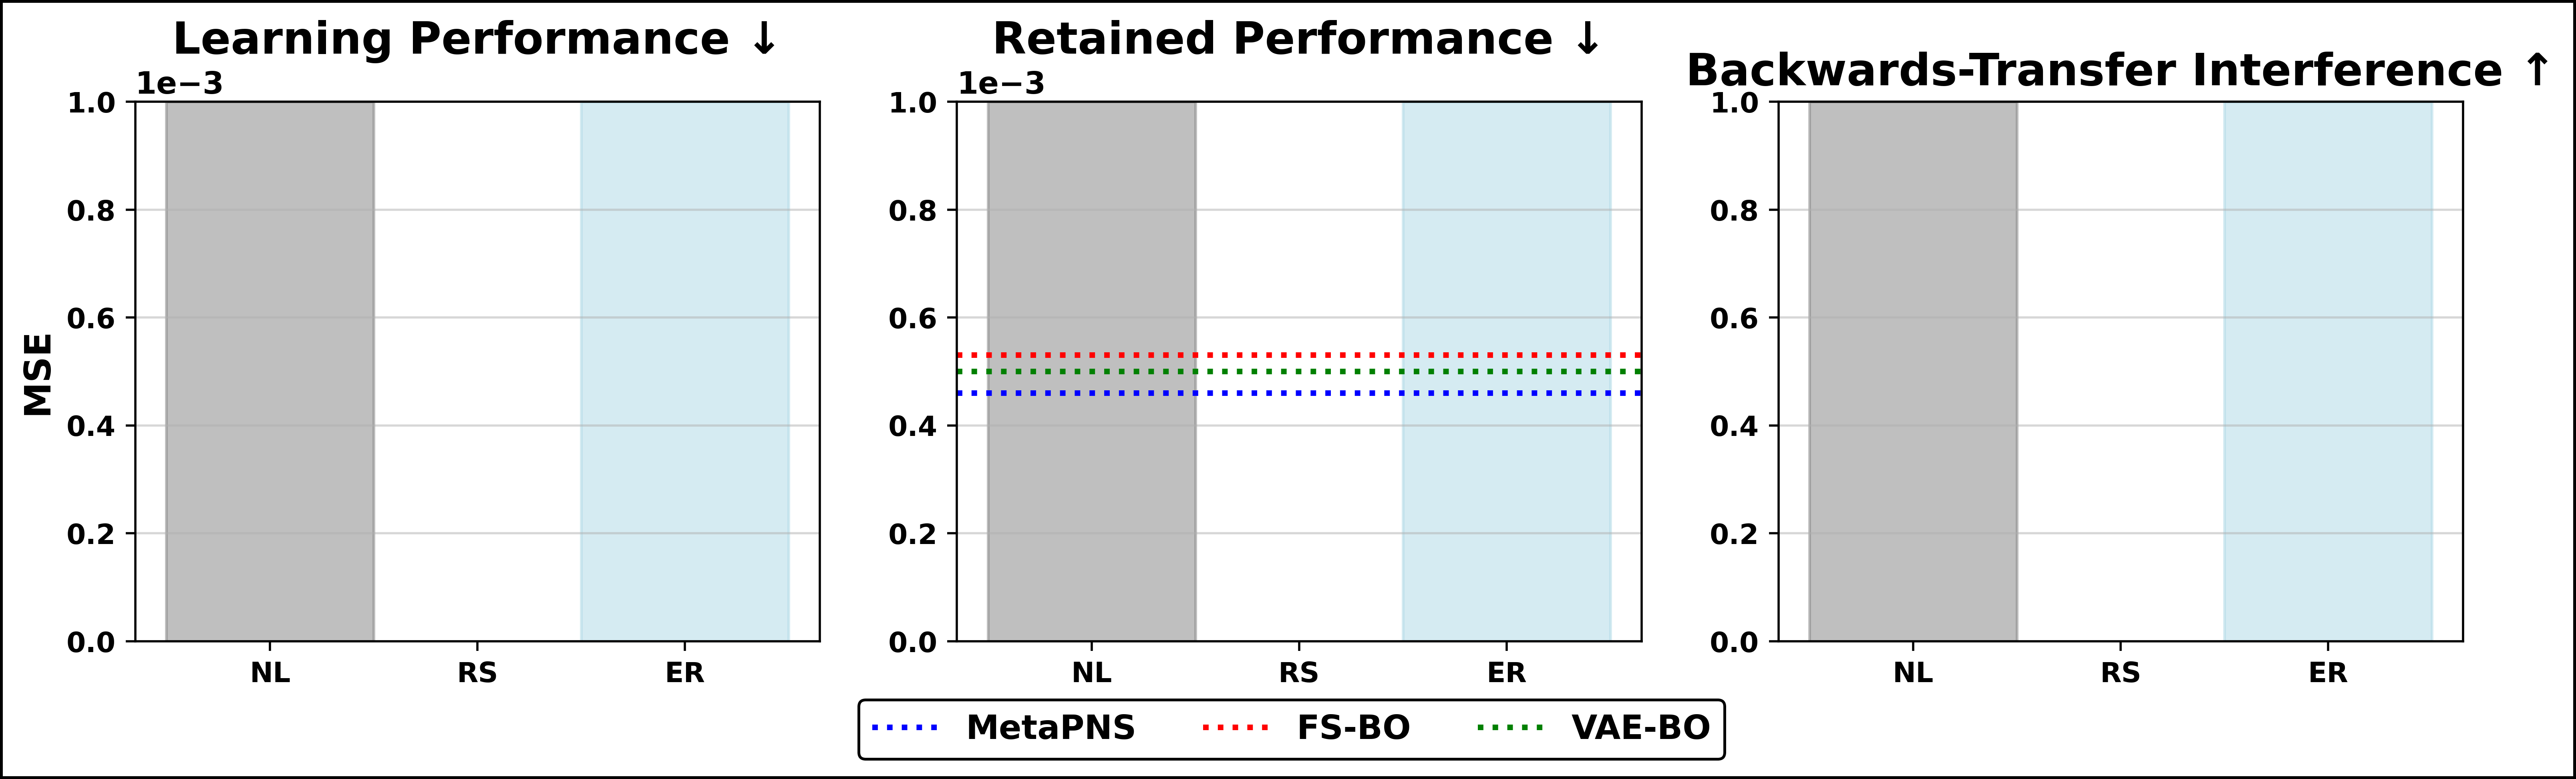

Error plotting PNS LP scc: name 'final_metrics' is not defined
Error plotting MAML-PNS LP scc: name 'final_metrics' is not defined
Error plotting CoMetaPNS LP scc: name 'final_metrics' is not defined
Error plotting PNS RP scc: name 'final_metrics' is not defined
Error plotting MAML-PNS RP scc: name 'final_metrics' is not defined
Error plotting CoMetaPNS RP scc: name 'final_metrics' is not defined
Error plotting PNS BTI scc: name 'final_metrics' is not defined
Error plotting MAML-PNS BTI scc: name 'final_metrics' is not defined
Error plotting CoMetaPNS BTI scc: name 'final_metrics' is not defined


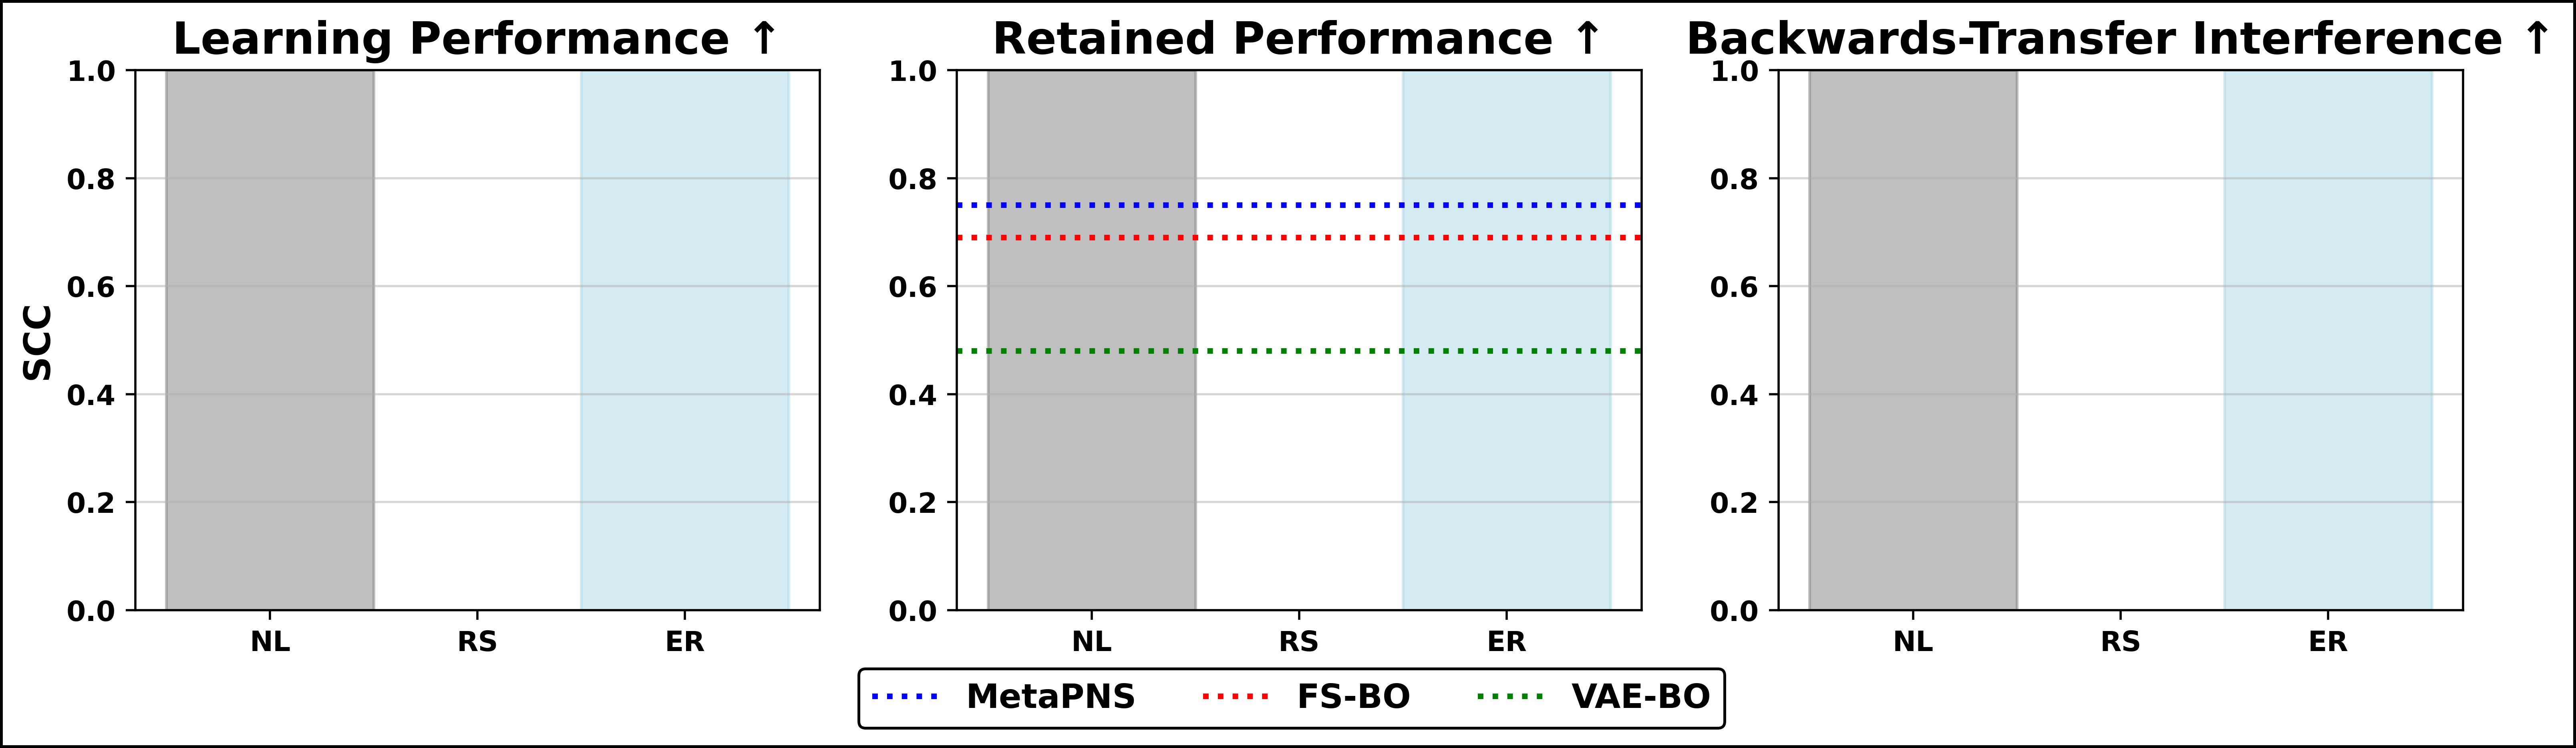

Error plotting PNS LP tcc: name 'final_metrics' is not defined
Error plotting MAML-PNS LP tcc: name 'final_metrics' is not defined
Error plotting CoMetaPNS LP tcc: name 'final_metrics' is not defined
Error plotting PNS RP tcc: name 'final_metrics' is not defined
Error plotting MAML-PNS RP tcc: name 'final_metrics' is not defined
Error plotting CoMetaPNS RP tcc: name 'final_metrics' is not defined
Error plotting PNS BTI tcc: name 'final_metrics' is not defined
Error plotting MAML-PNS BTI tcc: name 'final_metrics' is not defined
Error plotting CoMetaPNS BTI tcc: name 'final_metrics' is not defined


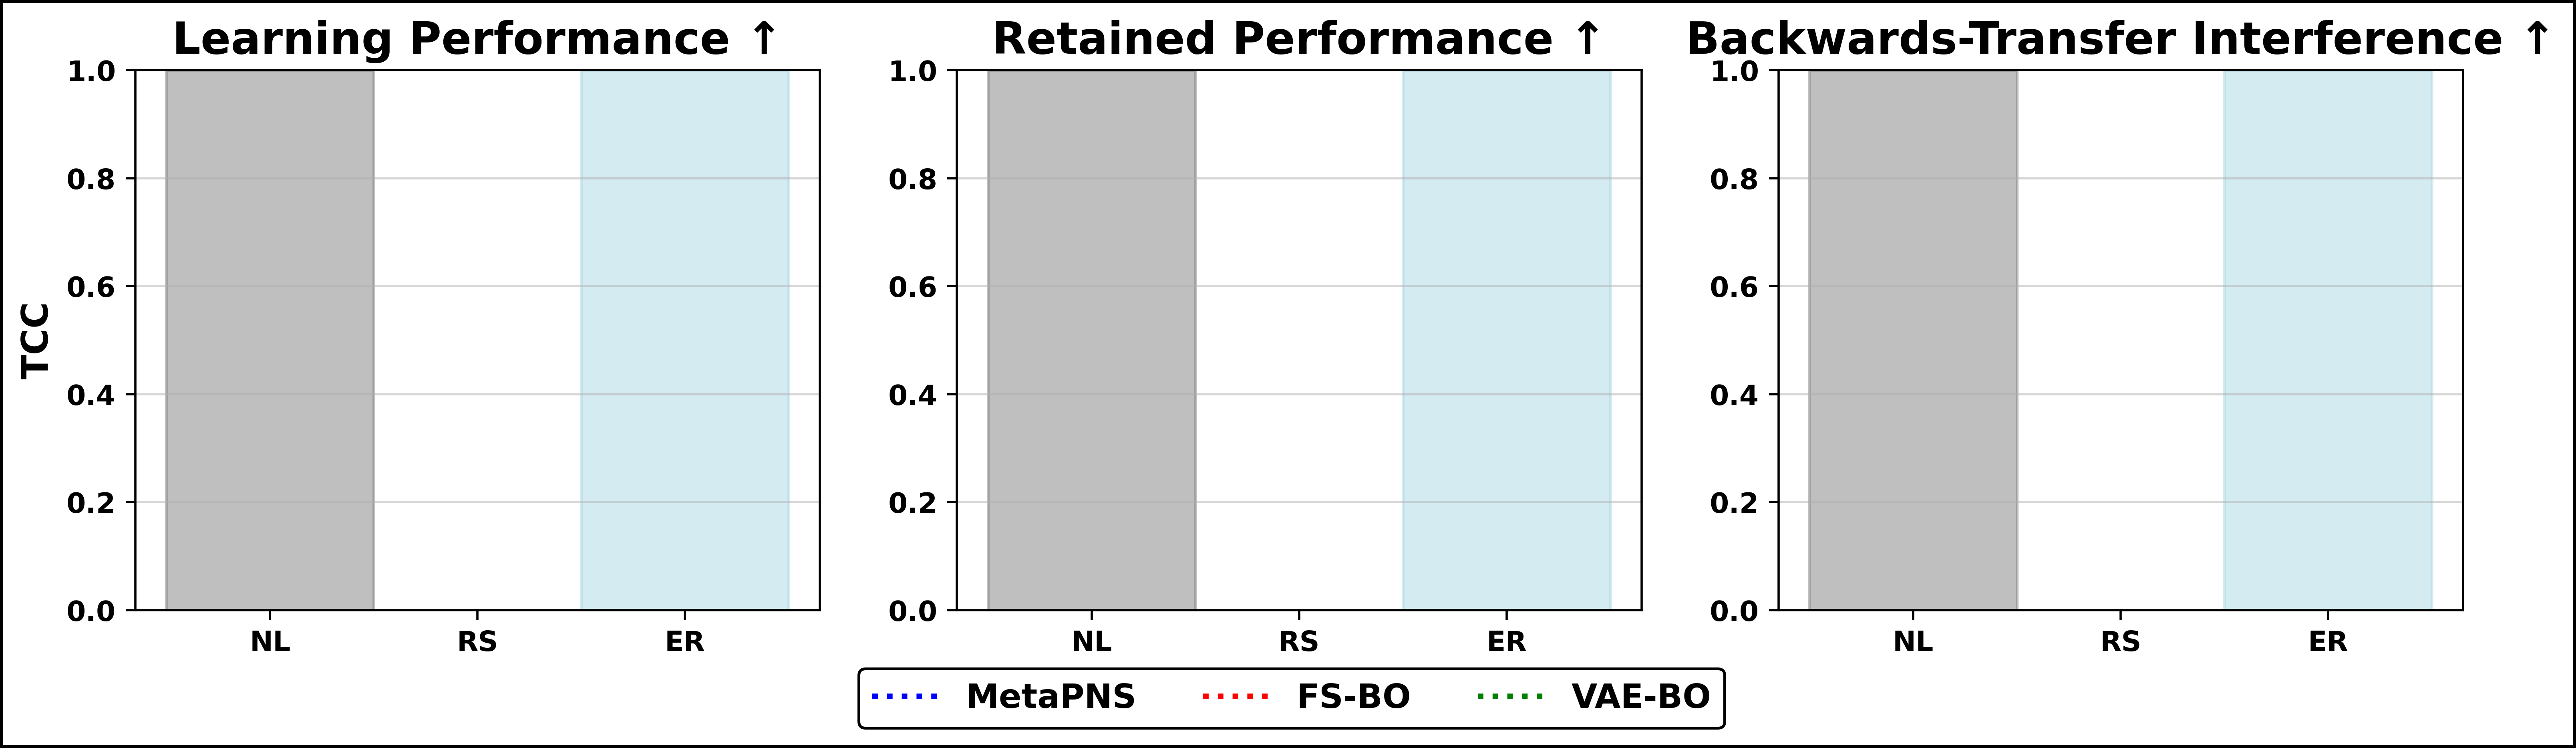

Error plotting PNS LP dcc: name 'final_metrics' is not defined
Error plotting MAML-PNS LP dcc: name 'final_metrics' is not defined
Error plotting CoMetaPNS LP dcc: name 'final_metrics' is not defined
Error plotting PNS RP dcc: name 'final_metrics' is not defined
Error plotting MAML-PNS RP dcc: name 'final_metrics' is not defined
Error plotting CoMetaPNS RP dcc: name 'final_metrics' is not defined
Error plotting PNS BTI dcc: name 'final_metrics' is not defined
Error plotting MAML-PNS BTI dcc: name 'final_metrics' is not defined
Error plotting CoMetaPNS BTI dcc: name 'final_metrics' is not defined


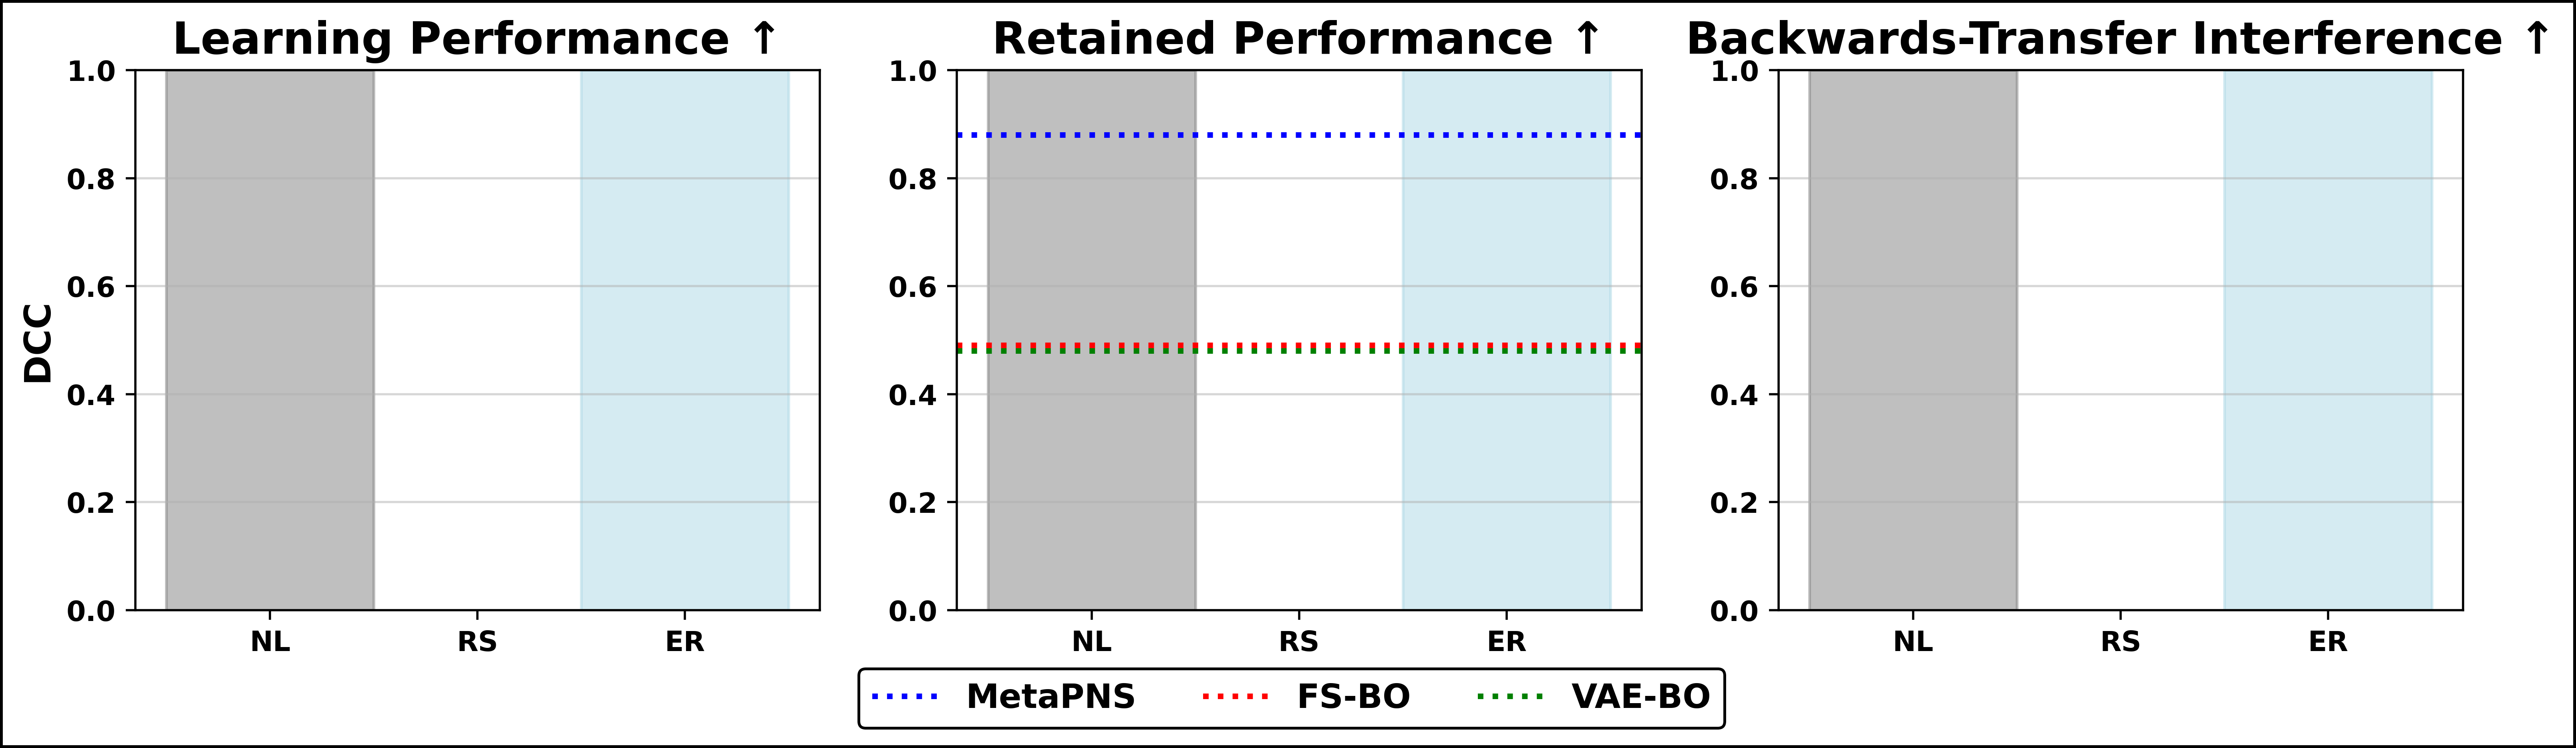

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

params = {'font.weight': 'bold'} 
plt.rcParams.update(params)

# Define baseline values for each metric type
baselines = {
    "mse": {
        "MetaPNS": 0.00046,
        "FS-BO": 0.00053,
        "VAE-BO": 0.00050
    },
    "scc": {
        "MetaPNS": 0.75,
        "FS-BO": 0.69,
        "VAE-BO": 0.48
    },
    "tcc": {
        "MetaPNS": -1,
        "FS-BO": -1,
        "VAE-BO": -1
    },
    "dcc": {
        "MetaPNS": 0.88,
        "FS-BO": 0.49,
        "VAE-BO": 0.48
    }
}

# Define line styles and colors for baselines
baseline_styles = {
    "FS-BO": {"color": "red", "linestyle": ":", "linewidth": 2},
    "VAE-BO": {"color": "green", "linestyle": ":", "linewidth": 2},
    "MetaPNS": {"color": "blue", "linestyle": ":", "linewidth": 2}
}

for metric_type in ["mse", "scc", "tcc", "dcc"]:
    categories = ['NL', 'RS', 'ER']
    x = np.arange(len(categories))
    bar_width = 0.25
    offsets = [-bar_width, 0, bar_width]

    fig, axes = plt.subplots(1, 3, figsize=(15, 3.5), dpi=500, sharex=True)
    models = ["PNS", "MAML-PNS", "CoMetaPNS"]

    label_font_size = 13
    title_font_size = 16
    legend_font_size = 12

    if metric_type == "mse":
        max_val = 0.001
    elif metric_type == "mae":
        max_val = 0.02
    else:
        max_val = 1.0

    for i in range(3):
        axes[i].axvspan(-0.5, 0.5, color='gray', alpha=0.5)
        axes[i].axvspan(1.5, 2.5, color='lightblue', alpha=0.5)

    # Plot each performance type
    for plot_idx, perf_type in enumerate(["LP", "RP", "BTI"]):
        for i, model in enumerate(models):
            try:
                means = []
                stds = []
                for mem in categories:
                    mean = final_metrics[model][mem][metric_type][perf_type]["mean"]
                    std = final_metrics[model][mem][metric_type][perf_type]["std"]
                    means.append(mean)
                    stds.append(std)
                    
                if metric_type == "mse" and perf_type == "BTI":
                    means = [-m for m in means]
        
                axes[plot_idx].bar(x + offsets[i], means, width=bar_width, 
                                label=model, yerr=stds, capsize=5)
            except Exception as e:
                print(f"Error plotting {model} {perf_type} {metric_type}: {str(e)}")
                continue

        # Add horizontal lines only for Retained Performance
        if perf_type == "RP":
            for baseline_name, value in baselines[metric_type].items():
                line = axes[plot_idx].axhline(
                    y=value,
                    **baseline_styles[baseline_name],
                    label=f"{baseline_name}"
                )

        direction = "↓" if metric_type in ["mse", "mae"] else "↑"
        titles = {
            "LP": f'Learning Performance {direction}',
            "RP": f'Retained Performance {direction}',
            "BTI": f'Backwards-Transfer Interference ↑'
        }
        
        if metric_type in ["mse", "mae"]:
            axes[plot_idx].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
            axes[plot_idx].yaxis.get_offset_text().set_fontsize(11)
            axes[plot_idx].yaxis.get_offset_text().set_fontweight('bold')
        
        axes[plot_idx].set_title(titles[perf_type], fontsize=title_font_size, fontweight='bold')
        
        if plot_idx == 0:
            axes[plot_idx].set_ylabel(metric_type.upper(), fontsize=label_font_size, fontweight='bold')
        else:
            axes[plot_idx].set_ylabel('')
            
        axes[plot_idx].set_xticks(x)
        axes[plot_idx].set_xticklabels(categories, fontweight='bold')
        
        if perf_type in ["LP", "RP"]:
            axes[plot_idx].set_ylim(0, max_val)
            
        axes[plot_idx].grid(True, axis='y', alpha=0.5)

    # Legend handling
    bar_handles, bar_labels = axes[0].get_legend_handles_labels()
    all_handles = bar_handles + [
        plt.Line2D([0], [0], **baseline_styles["MetaPNS"]),
        plt.Line2D([0], [0], **baseline_styles["FS-BO"]),
        plt.Line2D([0], [0], **baseline_styles["VAE-BO"])
    ]
    all_labels = bar_labels + ["MetaPNS", "FS-BO", "VAE-BO"]

    legend = fig.legend(all_handles, all_labels,
                       loc='upper center', 
                       bbox_to_anchor=(0.51, 0.05), 
                       ncol=6,
                       fontsize=legend_font_size)

    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_alpha(1)

    fig.patch.set_linewidth(2)
    fig.patch.set_edgecolor('black')

    plt.savefig(f"continual_metric_{metric_type.lower()}_flattened.svg", 
                bbox_inches="tight")
    plt.show()
    plt.close()